In [1]:
import torch 
import pandas as pd 
import numpy as np
import os
from lincs_gsnn.data.DXDTDataset import DXDTDataset
from torch.utils.data import DataLoader 

from lincs_gsnn.models.SplineWeightEmbedding import SplineWeightEmbedding

from matplotlib import pyplot as plt
import seaborn as sbn
from sklearn.metrics import r2_score

import networkx as nx 
import pickle as pkl

from pypath.utils import mapping
import warnings 

from pypath.utils import mapping

warnings.filterwarnings("ignore")

from lincs_gsnn.models.ODEFunc import ODEFunc
from lincs_gsnn.data.TrajDataset import TrajDataset
from torchdiffeq import odeint 

import gseapy as gp
from lincs_gsnn.explain.viz import annotate_edges, get_drug_edges, make_subgraph, plot_graph, axes_to_gif

from lincs_gsnn.explain.infer_edge_weights import infer_edge_weights

import statsmodels.api as sm

%load_ext autoreload
%autoreload 2

In [2]:
data = torch.load('/home/teddy/local/lincs-gsnn/workflow/runs/default/bionetwork/bionetwork.pt', weights_only=False)
model = torch.load('../workflow/runs/default/pretrain/pretrained_model.pt', weights_only=False)
dxdt_scale = torch.load('../workflow/runs/default/pretrain/dxdt_scale.pt', weights_only=False).item()
x_names = pd.read_csv('/home/teddy/local/lincs-traj/workflow/runs/exp/default_v02/output/predict_grid/gene_names.csv')['gene_names'].values.astype(str)
dxdt_meta = pd.read_csv('/home/teddy/local/lincs-traj/workflow/runs/exp/default_v02/output/predict_grid/dxdt_meta.csv')

In [3]:
uniprot_background = [x.split('__')[1] for x in data.node_names_dict['function']]
symbol_background = [] 

for uni in uniprot_background:
    try: 
        symbol_background.append( list(mapping.map_name(uni, 'uniprot', 'genesymbol'))[0] ) 
    except: 
        pass 

len(symbol_background)

1417

In [4]:
dxdt_meta.cell_iname.unique() 

array(['HME1', 'BT20', 'BT474', 'HS578T', 'MCF10A', 'MCF7', 'MDAMB231',
       'MDAMB468', 'SKBR3', 'T47D', 'ZR751'], dtype=object)

In [89]:
cell1 = 'HME1'
cell2 = 'MDAMB231'
drug = 'BRD-K49328571'
dose = 0.1

cond_cell1 = dxdt_meta[lambda x: (x.cell_iname == cell1) & (x.pert_id == drug) & (x.dose == dose)]
cond_cell2 = dxdt_meta[lambda x: (x.cell_iname == cell2) & (x.pert_id == drug) & (x.dose == dose)]

print('number obs cell1:', len(cond_cell1))
print('number obs cell2:', len(cond_cell2))

target_genes = x_names #['TP53']

obs_dir = '/home/teddy/local/lincs-traj/workflow/runs/exp/default_v02/output/predict_grid/dxdt/'

wt_cell1, SWE_cell1, metrics_cell1 = infer_edge_weights(model, data, cond_cell1, target_genes, obs_dir, dxdt_scale, 
                                        n_ctrl_pts=5, degree=3, prior=3, lr=5e-2, beta=1e-4, 
                                        epochs=400, batch_size=600, num_workers=2, dropout=0.1)

print()
wt_cell2, SWE_cell2, metrics_cell2 = infer_edge_weights(model, data, cond_cell2, target_genes, obs_dir, dxdt_scale, 
                                        n_ctrl_pts=5, degree=3, prior=3, lr=5e-2, beta=1e-4, 
                                        epochs=400, batch_size=600, num_workers=2, dropout=0.1)

number obs cell1: 100
number obs cell2: 100
Epoch 399, norm: 773.5283, mse: 0.0339, r2: 0.93182


In [90]:
def get_gsea(edge_mask, drug, data, model, background=None): 

    res = annotate_edges(model, edge_mask) 
    drug_edges = get_drug_edges(data, drug=drug) 
    G = make_subgraph(data, res, drug_edges) 

    genes = [G.nodes[n]['node_name'] for n in G.nodes()]
    genes = [x for x in genes if x is not None ]

    gsea = gp.enrichr(gene_list=genes, # or "./tests/data/gene_list.txt",
                    gene_sets=['GO_Biological_Process_2021'],
                    organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                    outdir=None, # don't write to disk
                    background=background, # background gene list
                    ).res2d 
    
    return gsea 


In [105]:
ress1 = [] 
for t in np.linspace(0, 99, 100): 
    print(f'Processing time {t}...', end='\r')

    edge_mask = wt_cell1[int(t)] > 0.5 

    ress1.append( 
        get_gsea(edge_mask, drug, data, model, background=symbol_background) 
    )

In [106]:
ress2 = [] 
for t in np.linspace(0, 99, 100): 
    print(f'Processing time {t}...', end='\r')

    edge_mask = wt_cell2[int(t)] > 0.5 

    ress2.append( 
        get_gsea(edge_mask, drug, data, model, background=symbol_background) 
    )

In [107]:
[x for x in ress2[0].Term.values if 'motility' in x.lower()]

['positive regulation of cell motility (GO:2000147)',
 'negative regulation of cell motility (GO:2000146)',
 'regulation of cell motility (GO:2000145)']

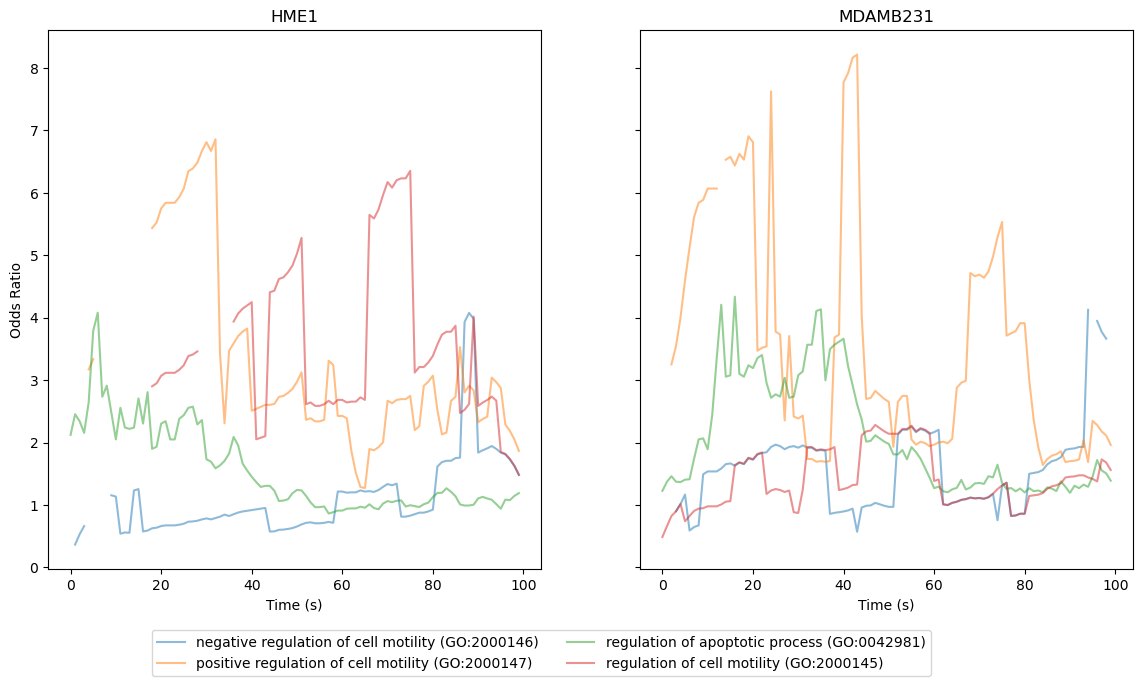

In [ ]:
terms = [#'MAPK cascade (GO:0000165)', 
         #'protein phosphorylation (GO:0006468)', 
         #'regulation of cell cycle (GO:0051726)', 
         #'positive regulation of cell population proliferation (GO:0008284)',
         #'regulation of signal transduction by p53 class mediator (GO:1901796)', 
         #'positive regulation of cell cycle (GO:0045787)', 
         #'regulation of gene expression (GO:0010468)',
         'negative regulation of cell motility (GO:2000146)',
         'positive regulation of cell motility (GO:2000147)',
         'regulation of apoptotic process (GO:0042981)',
         'regulation of cell motility (GO:2000145)']

_metric = 'P-value' #'Odds Ratio' #'P-value' # 'Odds Ratio', 'P-value', 'Adjusted P-value'
pvals_dict1 = {} 
for term in terms: 
    pvals_dict1[term] = [res[lambda x: x.Term == term][_metric].values[0] for res in ress1] 

pvals_dict2 = {} 
for term in terms: 
    pvals_dict2[term] = [res[lambda x: x.Term == term][_metric].values[0] for res in ress2] 

f,axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
for term, pvals in pvals_dict1.items(): 
    axes[0].plot(pvals, '-', label=term, alpha=0.5)

for term, pvals in pvals_dict2.items(): 
    axes[1].plot(pvals, '-', label=term, alpha=0.5)

axes[0].set_title(cell1)
axes[1].set_title(cell2)

axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel(_metric)

axes[1].set_xlabel('Time (s)')

if _metric in ['P-value', 'Adjusted P-value']:
    axes[0].set_yscale('log')
    axes[1].set_yscale('log')
    axes[0].axhline(0.05, color='k', linestyle='--')
    axes[1].axhline(0.05, color='k', linestyle='--')

# legend below plot 
axes[0].legend(bbox_to_anchor=(1., -0.1), loc='upper center', ncol=2)
plt.show() 

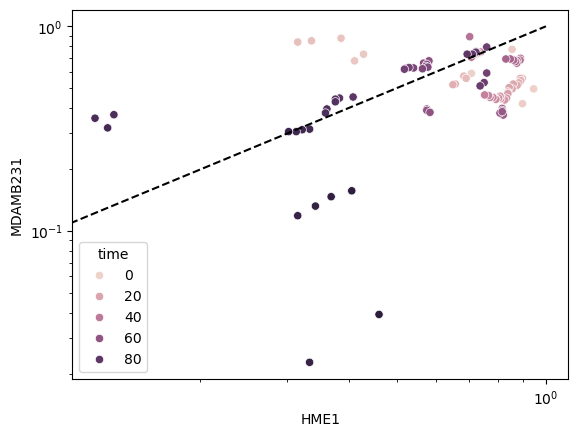

In [115]:
_term = 'negative regulation of cell motility (GO:2000146)'

tmp = pd.DataFrame({cell1: pvals_dict1[_term], 
                    cell2: pvals_dict2[_term], 
                    'time': np.linspace(0, 99, 100)})

plt.figure() 
sbn.scatterplot(data=tmp, x=cell1, y=cell2, hue='time')
plt.plot([0,1], [0, 1], 'k--')
plt.xscale('log')
plt.yscale('log')
plt.show() 

In [47]:
t = 50
wt_both = (wt_bt20[t] > 0.5) | (wt_hme1[t] > 0.5) 
wt_both.shape

(42564,)

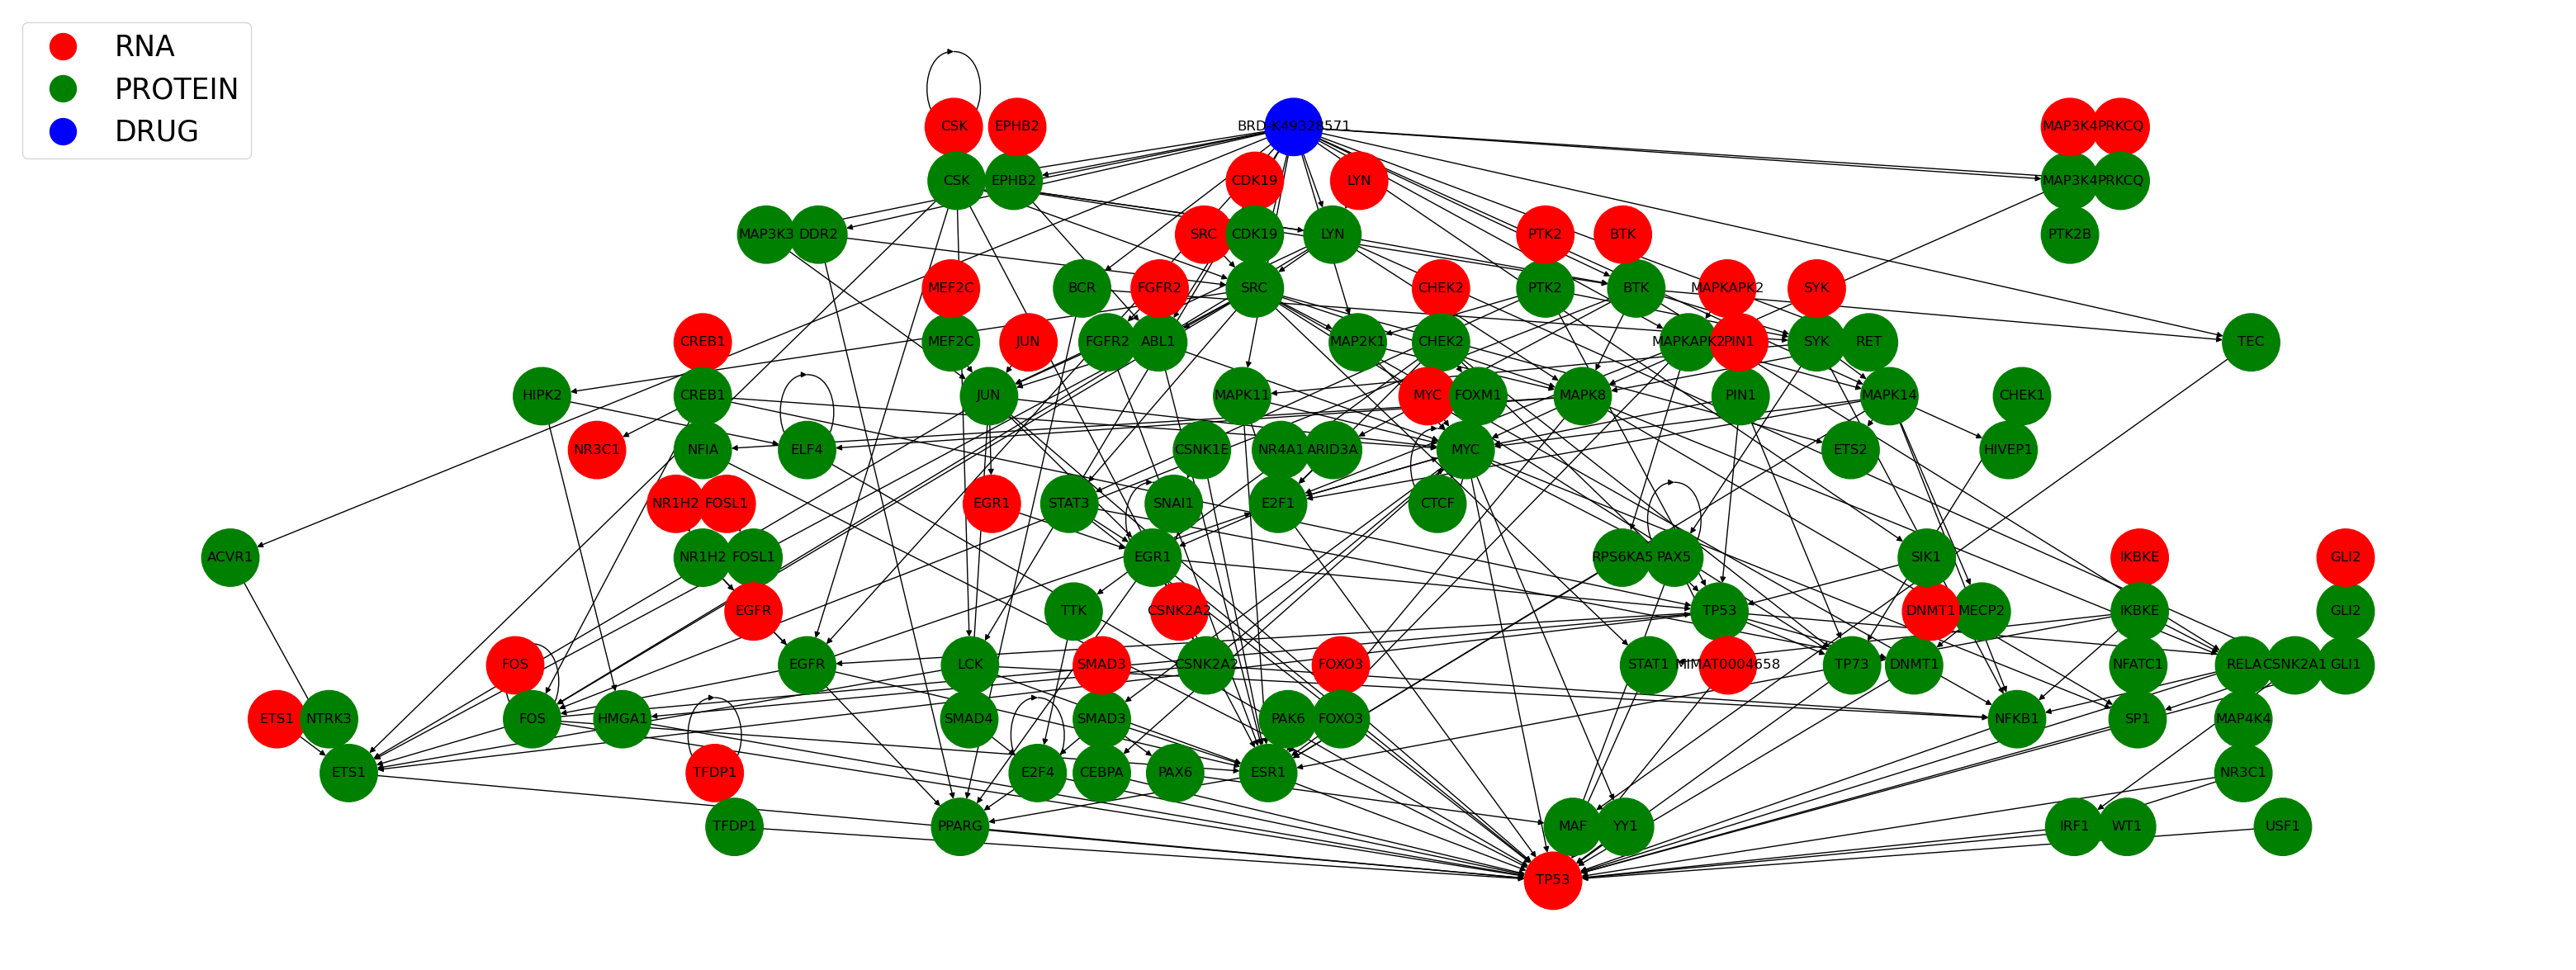

In [48]:
res = annotate_edges(model, wt_both) 
drug_edges = get_drug_edges(data, drug='BRD-K49328571') 
G = make_subgraph(data, res, drug_edges) 

H = nx.convert_node_labels_to_integers(G, label_attribute="node_label")
H_layout = nx.nx_pydot.pydot_layout(H, prog="dot")
pos = {H.nodes[n]["node_label"]: p for n, p in H_layout.items()}

f, ax = plot_graph(G, pos=pos)
xlim = ax.get_xlim()
ylim = ax.get_ylim() 

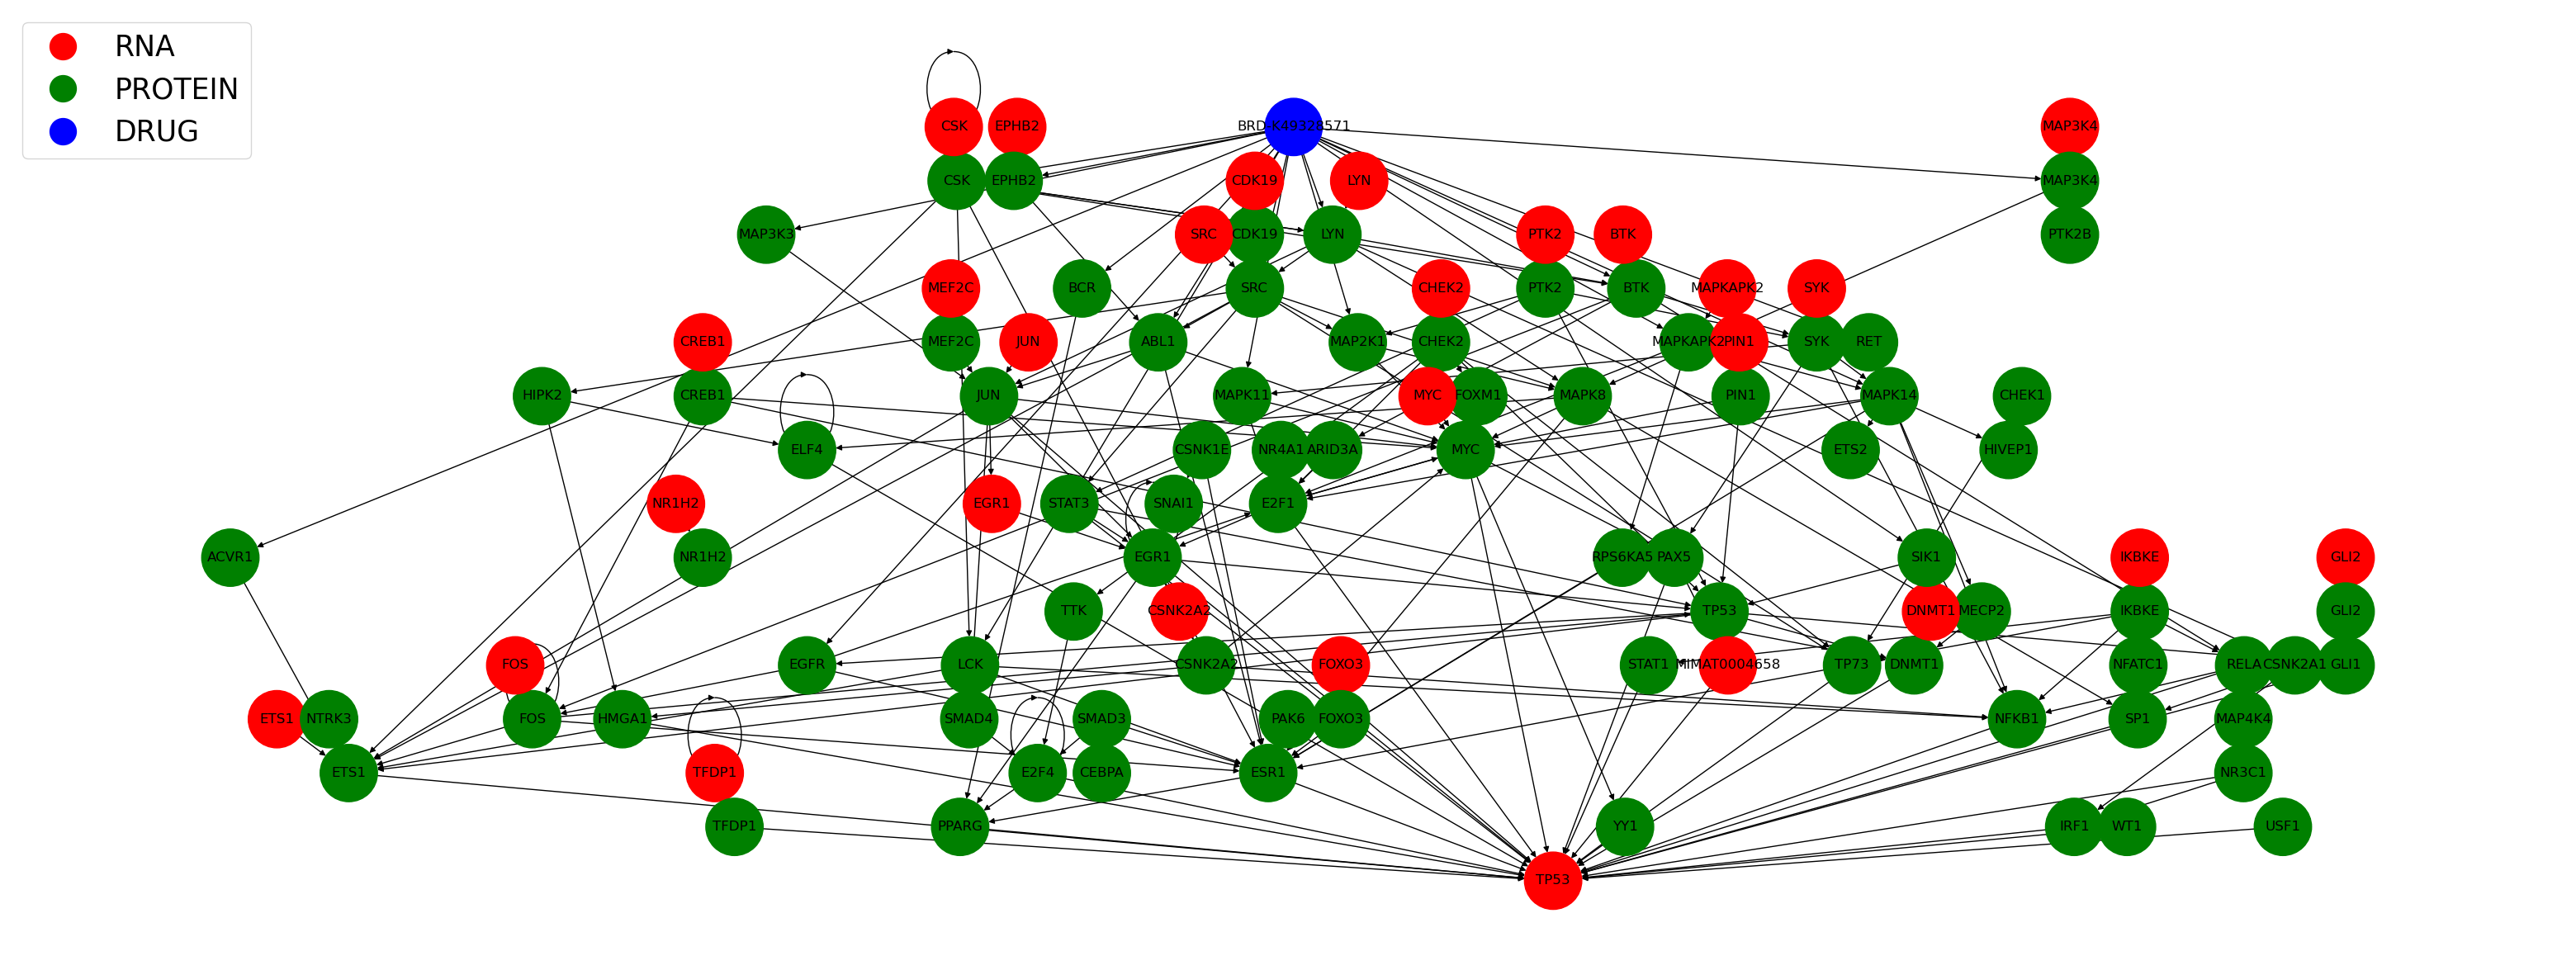

In [49]:
res_hme1 = annotate_edges(model,  (wt_hme1[t] > 0.5)) 
drug_edges_hme1 = get_drug_edges(data, drug='BRD-K49328571') 
G_hme1 = make_subgraph(data, res_hme1, drug_edges_hme1) 

f, ax = plot_graph(G_hme1, pos=pos, show=True, xlim=xlim, ylim=ylim)

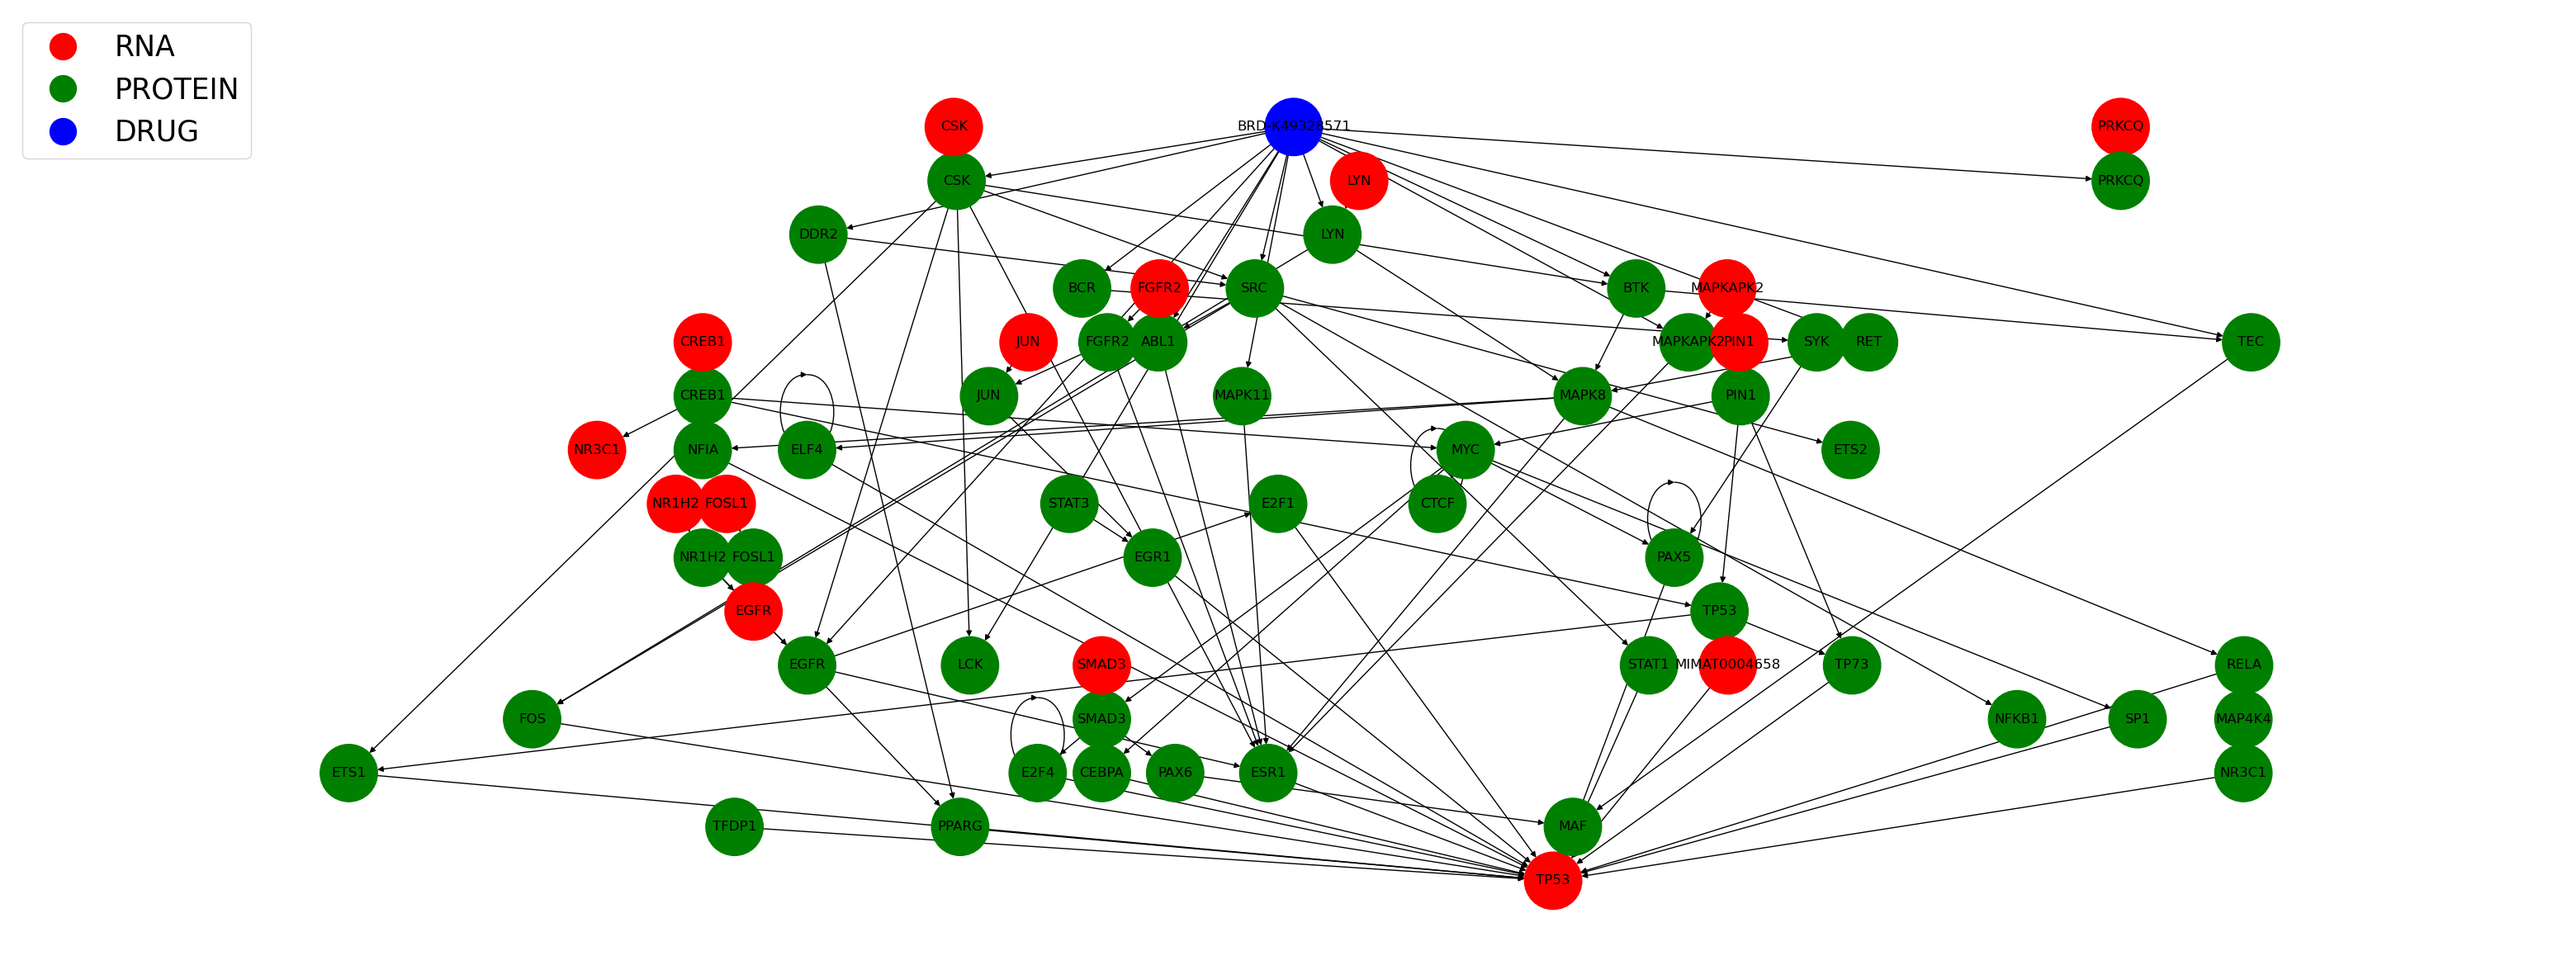

In [50]:
res_bt20 = annotate_edges(model,  (wt_bt20[t] > 0.5)) 
drug_edges_bt20 = get_drug_edges(data, drug='BRD-K49328571') 
G_bt20 = make_subgraph(data, res_bt20, drug_edges) 

f, ax = plot_graph(G_bt20, pos=pos, show=True, xlim=xlim, ylim=ylim)

In [51]:
uniprot_background = [x.split('__')[1] for x in data.node_names_dict['function']]
symbol_background = [] 

for uni in uniprot_background:
    try: 
        symbol_background.append( list(mapping.map_name(uni, 'uniprot', 'genesymbol'))[0] ) 
    except: 
        pass 

len(symbol_background)

1417

In [52]:
hme1_genes = [G_hme1.nodes[n]['node_name'] for n in G_hme1.nodes()]
bt20_genes = [G_bt20.nodes[n]['node_name'] for n in G_bt20.nodes()]

hme1_genes = [x for x in hme1_genes if x is not None ]
bt20_genes = [x for x in bt20_genes if x is not None ]


In [53]:
gsea_hme1 = gp.enrichr(gene_list=hme1_genes, # or "./tests/data/gene_list.txt",
                    gene_sets=['GO_Biological_Process_2021'],
                    organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                    outdir=None, # don't write to disk
                    background=symbol_background, # background gene list
                    ).res2d

gsea_bt20 = gp.enrichr(gene_list=bt20_genes, # or "./tests/data/gene_list.txt",
                    gene_sets=['GO_Biological_Process_2021'],
                    organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                    outdir=None, # don't write to disk
                    background=symbol_background, # background gene list
                    ).res2d

In [54]:
gsea = gsea_hme1.merge(gsea_bt20, how='inner', on='Term', suffixes=('_hme1', '_bt20')) 
gsea.head() 

Gene_set_hme1  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   
2  GO_Biological_Process_2021   
3  GO_Biological_Process_2021   
4  GO_Biological_Process_2021   

                                                Term  P-value_hme1  \
0  positive regulation of nucleic acid-templated ...  2.731529e-15   
1  positive regulation of transcription, DNA-temp...  2.580968e-14   
2  positive regulation of transcription by RNA po...  5.332958e-13   
3  regulation of transcription, DNA-templated (GO...  1.507560e-12   
4  positive regulation of pri-miRNA transcription...  6.963311e-11   

   Adjusted P-value_hme1  Old P-value_hme1  Old adjusted P-value_hme1  \
0           4.482438e-12                 0                          0   
1           2.117684e-11                 0                          0   
2           2.917128e-10                 0                          0   
3           6.184764e-10                 0                          0   
4           2.285359e-08                 0                          0   

   Odds Ratio_hme1  Combined Score_hme1  \
0         7.824522           262.386854   
1         6.220434           194.625113   
2         5.810358           164.198982   
3         5.398429           146.948084   
4        27.917910           652.937975   

                                          Genes_hme1  \
0  RET;FOXO3;GLI1;FOXM1;ETS1;RELA;EGFR;ETS2;GLI2;...   
1  RET;GLI1;FOXM1;NR3C1;ETS1;ETS2;GLI2;YY1;RPS6KA...   
2  CEBPA;FOXO3;GLI1;FOXM1;NR3C1;ETS1;RELA;EGFR;GL...   
3  RET;GLI1;FOXM1;NR3C1;ETS1;ETS2;GLI2;YY1;MECP2;...   
4  EGR1;JUN;SMAD3;WT1;STAT3;PPARG;FOS;FOXO3;NR3C1...   

                Gene_set_bt20  P-value_bt20  Adjusted P-value_bt20  \
0  GO_Biological_Process_2021  1.235131e-10           3.856697e-08   
1  GO_Biological_Process_2021  2.514322e-11           1.570194e-08   
2  GO_Biological_Process_2021  4.637674e-11           1.930818e-08   
3  GO_Biological_Process_2021  1.951389e-09           3.763534e-07   
4  GO_Biological_Process_2021  6.720267e-12           8.393614e-09   

   Old P-value_bt20  Old adjusted P-value_bt20  Odds Ratio_bt20  \
0                 0                          0         7.851429   
1                 0                          0         7.505415   
2                 0                          0         7.359147   
3                 0                          0         6.103065   
4                 0                          0        41.040936   

   Combined Score_bt20                                         Genes_bt20  
0           179.127782  RET;EGR1;JUN;SMAD3;STAT1;NR1H2;STAT3;PAX6;FOS;...  
1           183.180412  RET;CEBPA;CTCF;NR3C1;ETS1;RELA;EGFR;ETS2;MYC;A...  
2           175.105180  CEBPA;NR3C1;ETS1;RELA;EGFR;MYC;ABL1;E2F1;E2F4;...  
3           122.395291  RET;CEBPA;CTCF;NR3C1;ETS1;RELA;EGFR;ETS2;MYC;A...  
4          1055.814728  FOSL1;EGR1;JUN;SMAD3;STAT3;PPARG;FOS;NR3C1;ETS...

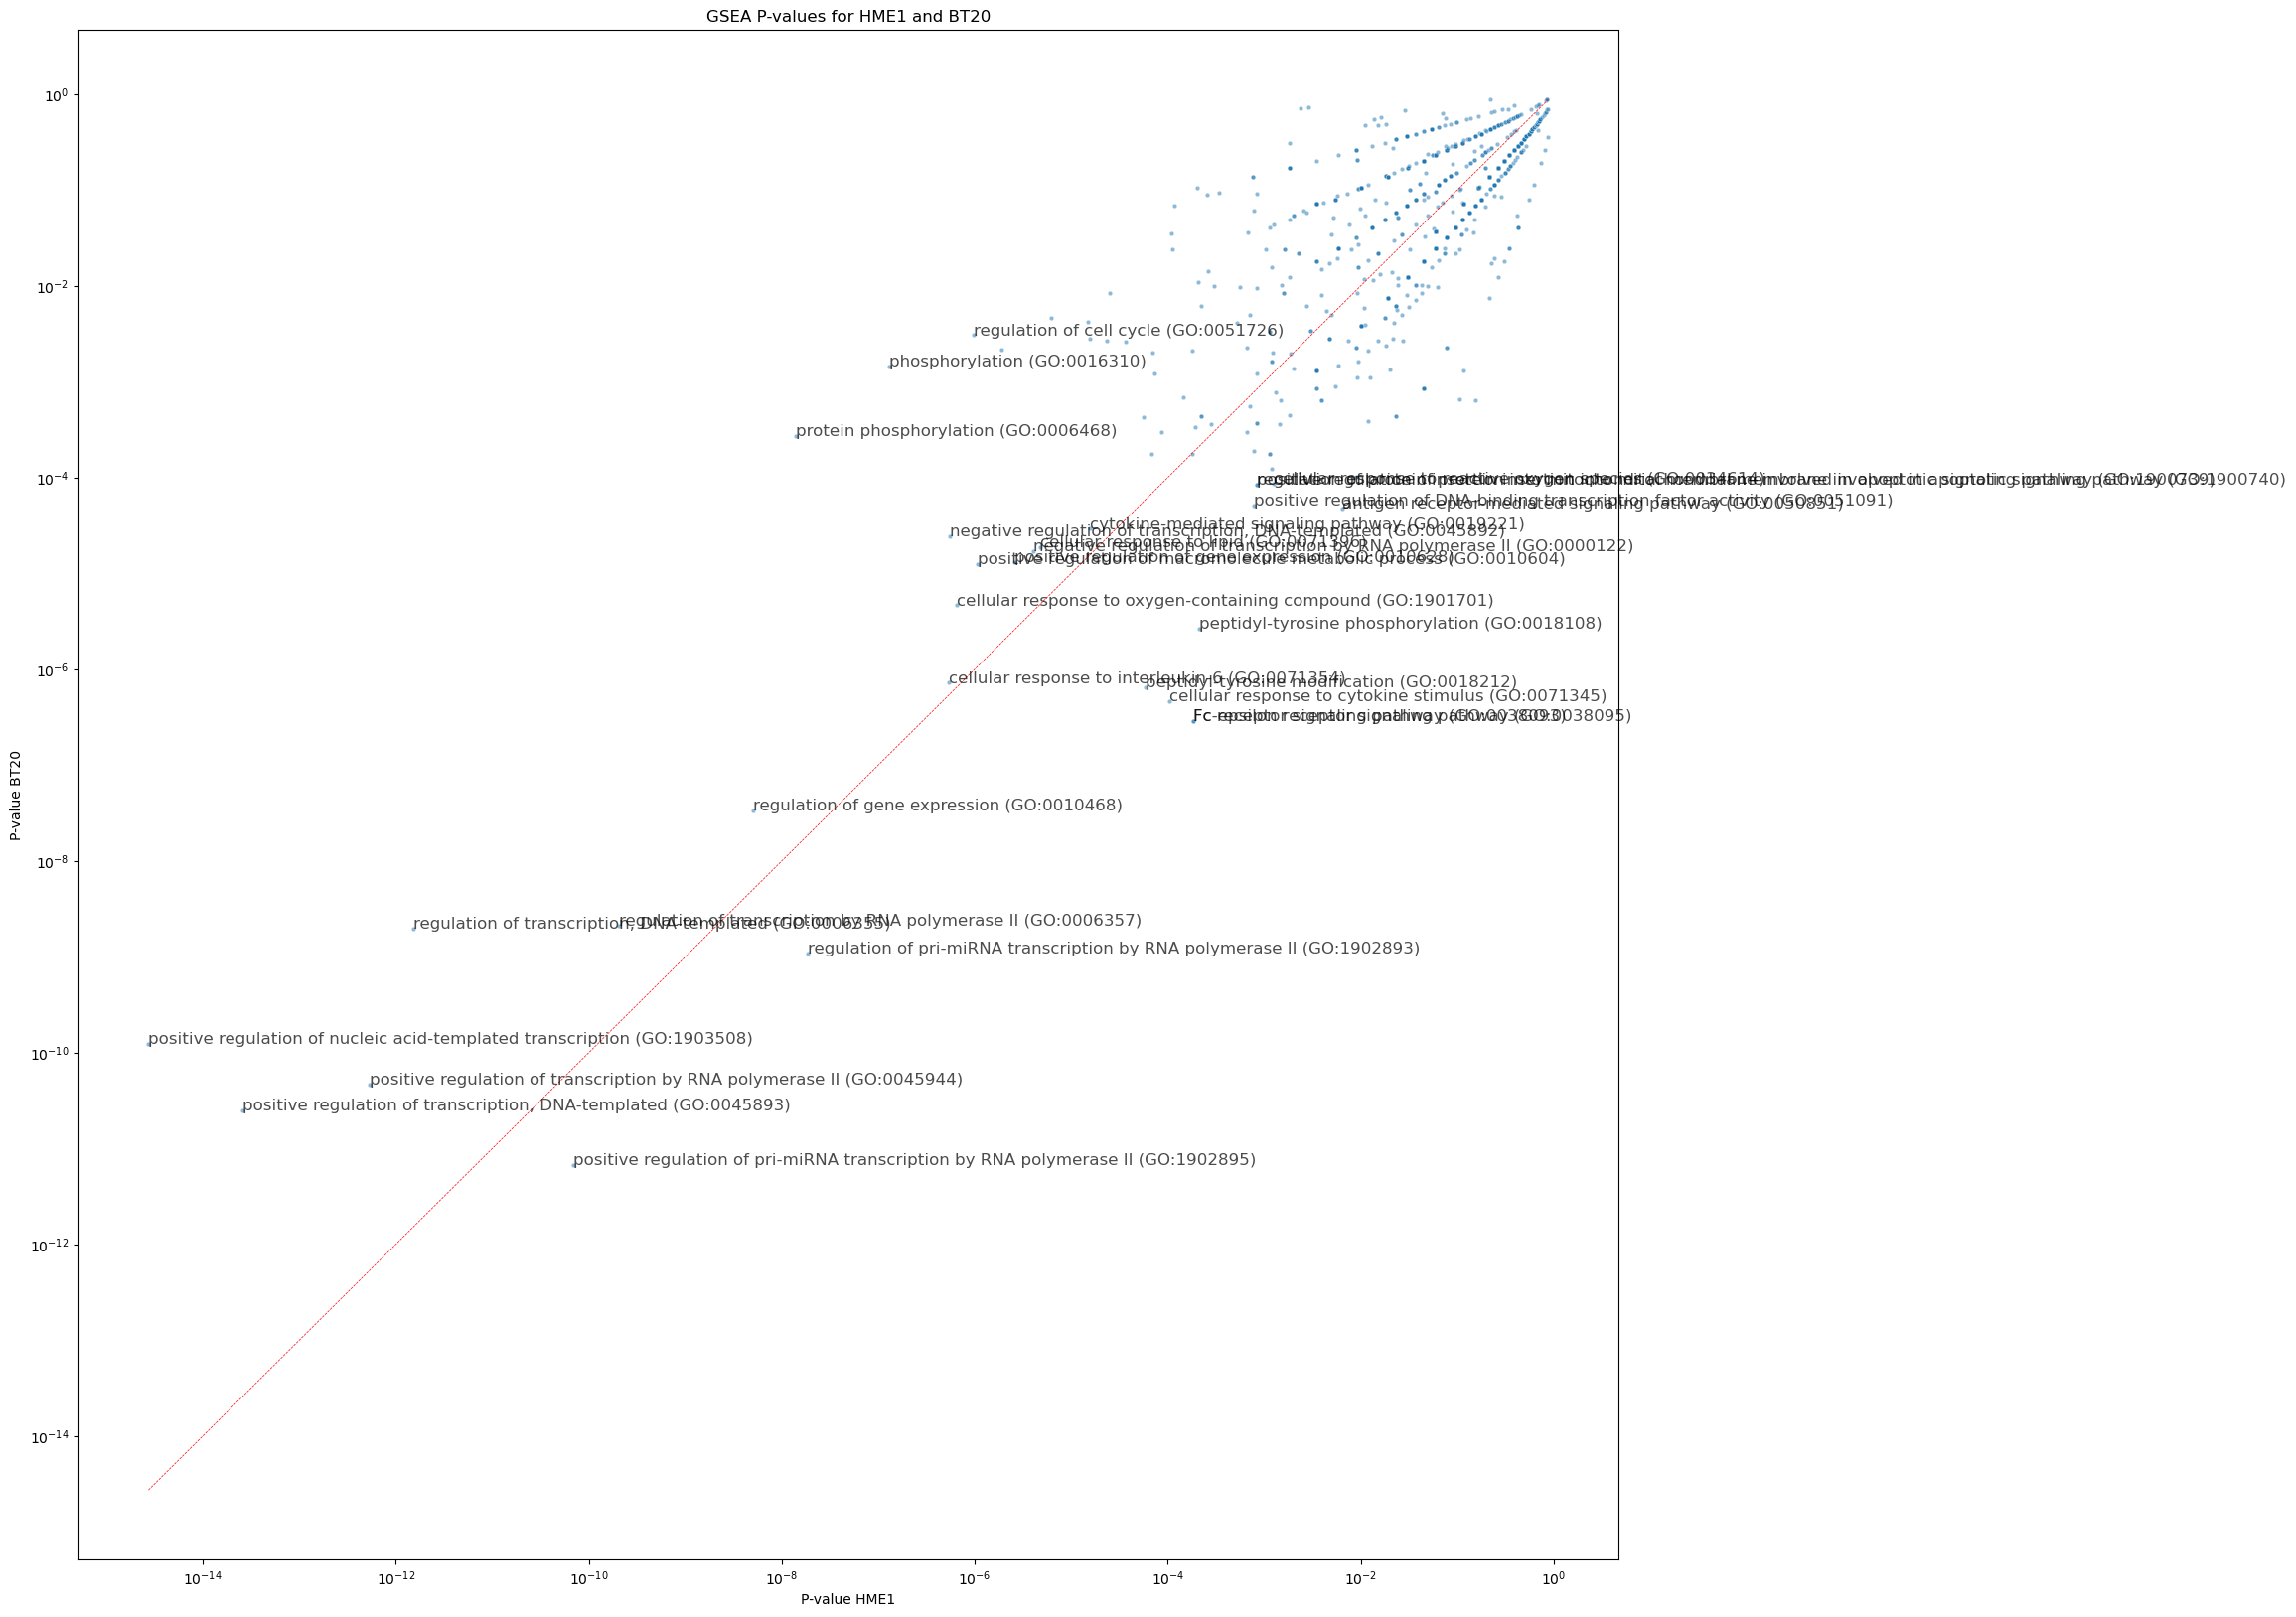

In [56]:
plt.figure(figsize=(20,20)) 
sbn.scatterplot(data=gsea, x='P-value_hme1', y='P-value_bt20', alpha=0.5, s=10)

_min_pval = gsea[['P-value_hme1', 'P-value_bt20']].min().min() 
_max_pval = gsea[['P-value_hme1', 'P-value_bt20']].max().max() 

plt.plot([_min_pval, _max_pval], [_min_pval, _max_pval], color='red', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('P-value HME1')
plt.ylabel('P-value BT20')
plt.title('GSEA P-values for HME1 and BT20') 

# label outliers 
for i, row in gsea.iterrows():
    if row['P-value_hme1'] < 1e-6 or row['P-value_bt20'] < 1e-4:
        plt.annotate(row['Term'], (row['P-value_hme1'], row['P-value_bt20']), fontsize=12, alpha=0.7)

plt.show() 

In [ ]:
hme1_genes = [G_hme1.nodes[n]['node_name'] for n in G_hme1.nodes()]
bt20_genes = [G_bt20.nodes[n]['node_name'] for n in G_bt20.nodes()]
background = list(set(hme1_genes + bt20_genes))

# genes that are important to HME1 (normal) drug response but not to BT20 
diff_genes1 = list( set(hme1_genes) - set(bt20_genes) )

# genes that are important to BT20 (cancer) drug response but not to HME1
diff_genes2 = list( set(bt20_genes) - set(hme1_genes)) 

In [23]:
gsea_df1 = gp.enrichr(gene_list=diff_genes1, # or "./tests/data/gene_list.txt",
                    gene_sets=['GO_Biological_Process_2021'],
                    organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                    outdir=None, # don't write to disk
                    background=background, # background gene list
                    ).res2d

gsea_df2 = gp.enrichr(gene_list=diff_genes2, # or "./tests/data/gene_list.txt",
                    gene_sets=['GO_Biological_Process_2021'],
                    organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                    outdir=None, # don't write to disk
                    background=background, # background gene list
                    ).res2d

In [29]:
gsea_df1.head(10).Term.values.tolist()

['regulation of BMP signaling pathway (GO:0030510)',
 'heart trabecula morphogenesis (GO:0061384)',
 'endothelial cell proliferation (GO:0001935)',
 'negative regulation of BMP signaling pathway (GO:0030514)',
 'negative regulation of cellular response to growth factor stimulus (GO:0090288)',
 'positive regulation of BMP signaling pathway (GO:0030513)',
 'negative regulation of transmembrane receptor protein serine/threonine kinase signaling pathway (GO:0090101)',
 'BMP signaling pathway (GO:0030509)',
 'cellular response to BMP stimulus (GO:0071773)',
 'artery development (GO:0060840)']

In [27]:
gsea_df2.head(10).Term.values.tolist()

['negative regulation of endothelial cell apoptotic process (GO:2000352)',
 'negative regulation of epithelial cell apoptotic process (GO:1904036)',
 'regulation of endothelial cell apoptotic process (GO:2000351)',
 'angiogenesis involved in wound healing (GO:0060055)',
 'regulation of p38MAPK cascade (GO:1900744)',
 'positive regulation of p38MAPK cascade (GO:1900745)',
 'negative regulation of canonical Wnt signaling pathway (GO:0090090)',
 'chromatin organization (GO:0006325)',
 'smoothened signaling pathway (GO:0007224)',
 'negative regulation of Wnt signaling pathway (GO:0030178)']

In [56]:
prism = pd.read_csv('/home/teddy/local/data/primary-screen-replicate-collapsed-logfold-change.csv')
prism.head() 

Unnamed: 0  BRD-A00077618-236-07-6::2.5::HTS  \
0             ACH-000001                         -0.015577   
1             ACH-000007                         -0.095730   
2             ACH-000008                          0.379480   
3  ACH-000010_FAILED_STR                          0.118890   
4             ACH-000011                          0.145346   

   BRD-A00100033-001-08-9::2.5::HTS  BRD-A00147595-001-01-5::2.5::HTS  \
0                         -0.449332                          0.489379   
1                          0.257943                          0.772349   
2                         -0.596132                          0.548056   
3                         -0.231615                          0.621937   
4                         -0.499274                          0.267470   

   BRD-A00218260-001-03-4::2.5::HTS  BRD-A00376169-001-01-6::2.5::HTS  \
0                          0.206675                          0.272730   
1                         -0.438502                         -0.732832   
2                          0.422269                         -0.216986   
3                         -0.202707                         -1.005139   
4                          0.157804                         -0.272286   

   BRD-A00520476-001-07-4::2.5::HTS  BRD-A00546892-001-02-6::2.5::HTS  \
0                          0.021036                         -0.025460   
1                          0.779201                          0.426523   
2                          0.081866                          0.145335   
3                         -0.213739                          0.020246   
4                          0.207768                          0.004464   

   BRD-A00578795-001-04-3::2.5::HTS  BRD-A00758722-001-04-9::2.5::HTS  ...  \
0                          0.467158                         -0.736306  ...   
1                         -1.288508                         -0.476133  ...   
2                         -0.570841                         -0.512119  ...   
3                         -0.795278                               NaN  ...   
4                         -0.191680                         -0.310375  ...   

   BRD-K98557884-001-01-6::2.5::MTS004  \
0                             0.429238   
1                            -0.471486   
2                            -0.111951   
3                             0.200605   
4                            -0.076863   

   BRD-K99077012-001-01-9::2.332734192::MTS004  \
0                                     0.204841   
1                                     0.212998   
2                                     0.534787   
3                                    -0.075356   
4                                     0.026002   

   BRD-K99199077-001-16-1::2.603211317::MTS004  \
0                                     0.150055   
1                                    -0.123230   
2                                     0.206642   
3                                     0.610310   
4                                     0.139921   

   BRD-K99431849-001-01-7::2.500018158::MTS004  \
0                                    -0.575404   
1                                     0.625527   
2                                    -0.410153   
3                                    -0.019413   
4                                    -0.261704   

   BRD-K99447003-335-04-1::2.37737659::MTS004  \
0                                   -0.101247   
1                                    0.383198   
2                                   -0.560722   
3                                   -0.202971   
4                                    0.085339   

   BRD-K99506538-001-03-8::2.5::MTS004  \
0                             0.399233   
1                             0.212031   
2                            -0.036088   
3                             0.218158   
4                             0.447482   

   BRD-K99616396-001-05-1::2.499991421::MTS004  \
0                                    -0.127658   
1                                     0.349225   
2

In [59]:
druginfo = pd.read_csv('/home/teddy/local/data/primary-screen-replicate-collapsed-treatment-info.csv') 
druginfo.head()

column_name                broad_id  \
0  BRD-A00055058-001-01-0::2.325889319::MTS004  BRD-A00055058-001-01-0   
1          BRD-A00842753-001-01-9::2.5::MTS004  BRD-A00842753-001-01-9   
2          BRD-A02232681-001-01-8::2.5::MTS004  BRD-A02232681-001-01-8   
3          BRD-A04447196-001-01-8::2.5::MTS004  BRD-A04447196-001-01-8   
4   BRD-A04971881-003-01-3::2.65294603::MTS004  BRD-A04971881-003-01-3   

         name      dose screen_id                             moa  \
0     RS-0481  2.325889    MTS004                 immunostimulant   
1  oleuropein  2.500000    MTS004       estrogen receptor agonist   
2  isoleucine  2.500000    MTS004                             NaN   
3   gepefrine  2.500000    MTS004     adrenergic receptor agonist   
4  cloranolol  2.652946    MTS004  adrenergic receptor antagonist   

                              target disease.area   indication  \
0                                NaN          NaN          NaN   
1                              GPER1          NaN          NaN   
2  ACADSB, BCAT1, BCAT2, IARS, IARS2          NaN          NaN   
3                                NaN   cardiology  hypotension   
4                ADRB1, ADRB2, ADRB3          NaN          NaN   

                                              smiles     phase  
0             CC(NC(=O)C1CSCN1C(=O)c1ccccc1)c1ccccc1   Phase 2  
1  COC(=O)C1=COC(OC2OC(CO)C(O)C(O)C2O)\C(=C/C)C1C...   Phase 2  
2                                   CCC(C)C(N)C(O)=O  Launched  
3                                  CC(N)Cc1cccc(O)c1  Launched  
4                     CC(C)(C)NCC(O)COc1cc(Cl)ccc1Cl  Launched

In [ ]:
cellinfo = pd.read_csv('/home/teddy/local/data/cellinfo_beta.txt', sep='\t')[['cell_iname', '']]
cellinfo.head()

cell_iname cellosaurus_id donor_age  donor_age_death  \
0       1HAE            NaN       NaN              NaN   
1       AALE            NaN       NaN              NaN   
2  AG06263_2            NaN       NaN              NaN   
3  AG06840_A            NaN       NaN              NaN   
4  AG078N1_1            NaN       NaN              NaN   

   donor_disease_age_onset doubling_time growth_medium provider_catalog_id  \
0                      NaN           NaN           NaN                 NaN   
1                      NaN           NaN           NaN                 NaN   
2                      NaN           NaN           NaN                 NaN   
3                      NaN           NaN           NaN                 NaN   
4                      NaN           NaN           NaN                 NaN   

  feature_id cell_type donor_ethnicity donor_sex donor_tumor_phase  \
0        NaN    normal         Unknown   Unknown           Unknown   
1        NaN    normal         Unknown   Unknown           Unknown   
2        NaN     tumor         Unknown   Unknown           Unknown   
3        NaN     tumor         Unknown   Unknown           Unknown   
4        NaN     tumor         Unknown   Unknown           Unknown   

  cell_lineage primary_disease                   subtype provider_name  \
0      unknown         unknown  normal fibroblast sample           NaN   
1      unknown         unknown  normal epithelium sample           NaN   
2      unknown         unknown                   unknown           NaN   
3      unknown         unknown                   unknown           NaN   
4      unknown         unknown                   unknown           NaN   

  growth_pattern ccle_name cell_alias  
0        unknown       NaN        NaN  
1        unknown       NaN        NaN  
2        unknown       NaN        NaN  
3        unknown       NaN        NaN  
4        unknown       NaN        NaN

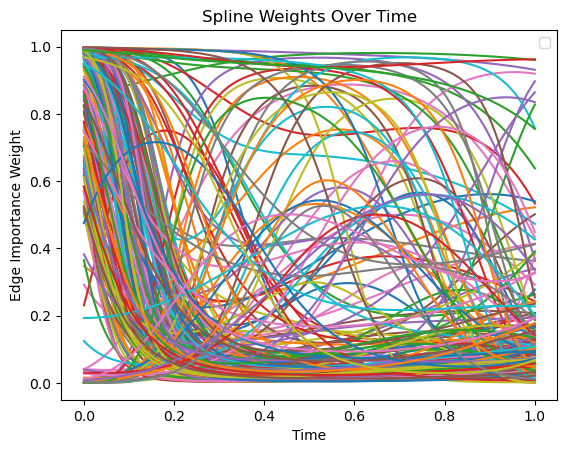

In [18]:
plt.figure() 
for i in (wt > 0.5).any(0).nonzero().ravel().detach().cpu().numpy(): 
    plt.plot(t.cpu().numpy(), wt[:, i].numpy())
plt.xlabel('Time')
plt.ylabel('Edge Importance Weight')
plt.title('Spline Weights Over Time')
plt.legend()
plt.show()

In [19]:
wt_all = (wt > 0.5).any(0)

In [20]:
from lincs_gsnn.explain.viz import annotate_edges, get_drug_edges, make_subgraph, plot_graph, axes_to_gif

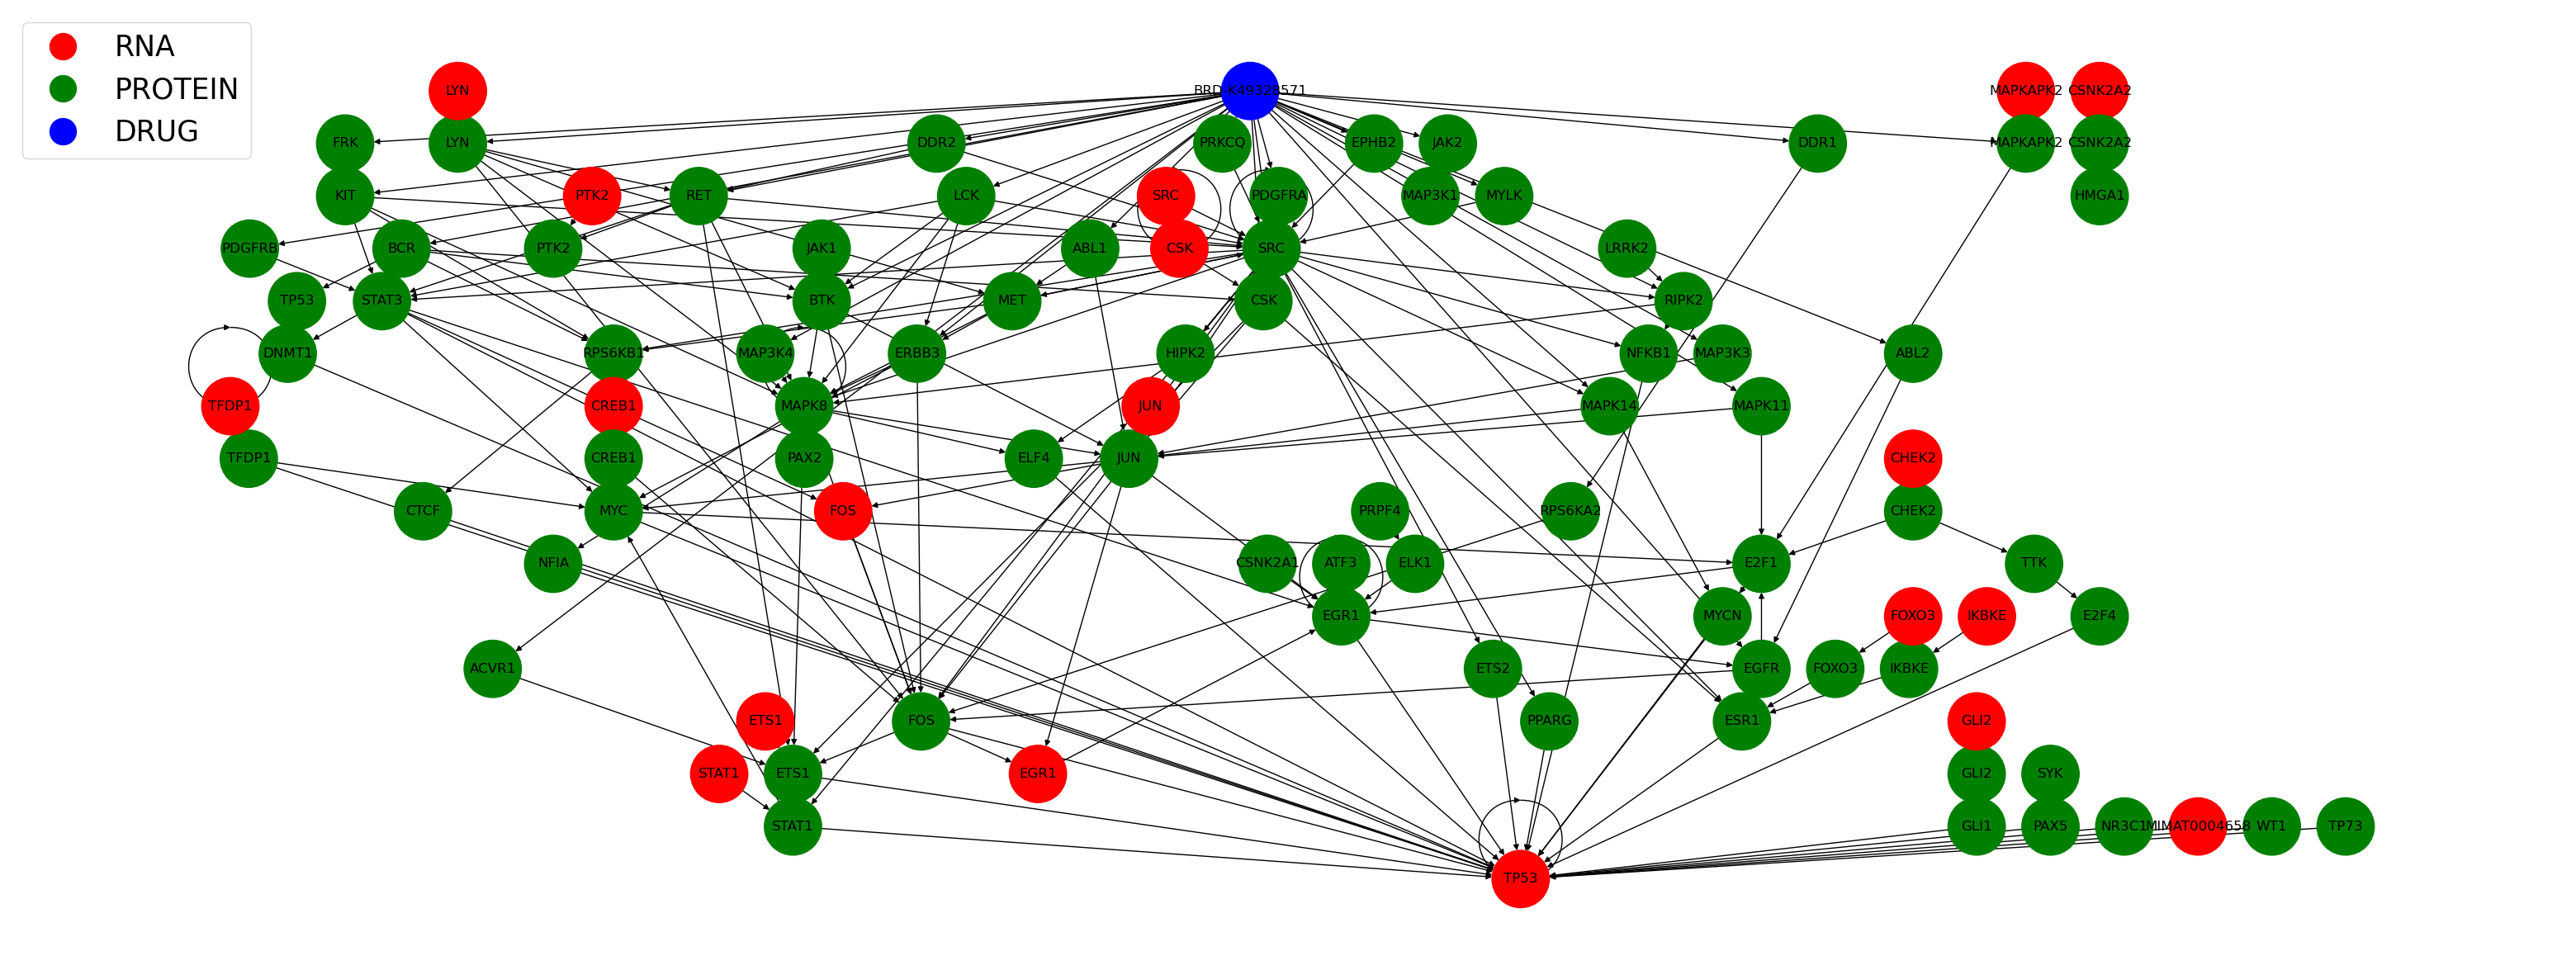

In [21]:
res = annotate_edges(model, wt_all) 
drug_edges = get_drug_edges(data, drug) 
G = make_subgraph(data, res, drug_edges) 

H = nx.convert_node_labels_to_integers(G, label_attribute="node_label")
H_layout = nx.nx_pydot.pydot_layout(H, prog="dot")
pos = {H.nodes[n]["node_label"]: p for n, p in H_layout.items()}

f, ax = plot_graph(G, pos=pos)
xlim = ax.get_xlim()
ylim = ax.get_ylim() 

In [22]:
def get_frame(model, w, data, drug, pos): 
    res = annotate_edges(model, w) 
    drug_edges = get_drug_edges(data, drug) 
    G = make_subgraph(data, res, drug_edges) 
    f, ax = plot_graph(G, pos=pos, show=False, xlim=xlim, ylim=ylim)
    return ax 

In [23]:
axes_list = [] 
for i in range(len(wt)):
    print(f'Frame {i:03d}', end='\r')
    axes_list.append( get_frame(model, wt[i] > 0.5, data, drug, pos) ) 

len(axes_list)
    

300

In [24]:
axes_to_gif(axes_list, 'TP53_Dasatinib_HME1.gif', fps=1)

✅  Saved 300-frame GIF ➜  TP53_Dasatinib_HME1.gif


In [25]:

def annotate_edges(model, edge_weight): 

    res = pd.DataFrame({'src': np.array(model.homo_names)[model.edge_index[:, model.function_edge_mask][0].cpu()],
                     'dst': np.array(model.homo_names)[model.edge_index[:, model.function_edge_mask][1].cpu()],
                     'weight': edge_weight.detach().cpu().numpy()[model.function_edge_mask.cpu()]})

    res = res.assign(src_uniprot = [x.split('__')[1] for x in res.src])
    res = res.assign(dst_uniprot = [x.split('__')[1] for x in res.dst])

    res = res.assign(src_type = [x.split('__')[0] for x in res.src])
    res = res.assign(dst_type = [x.split('__')[0] for x in res.dst])
    
    res = res.sort_values('weight', ascending=False)

    return res 

In [26]:
def run_weight_gsea(model, w, num_retries=10): 

    res = annotate_edges(model, w)

    uni_list = list(set(res[lambda x: x.weight > 0.5].src_uniprot.values.tolist() + res[lambda x: x.weight > 0.5].dst_uniprot.values.tolist()))

    gene_list = [] 
    for uniprot_id in uni_list: 
        try: 
            gene_list.append( list(mapping.map_name(uniprot_id, 'uniprot', 'genesymbol'))[0] )
        except: 
            pass 
    
    passed = False
    ii = 0 
    while not passed:
        try: 
            enr = gp.enrichr(gene_list=gene_list, # or "./tests/data/gene_list.txt",
                    gene_sets=['GO_Biological_Process_2021'],
                    organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                    outdir=None, # don't write to disk
                    )
            passed = True
        except: 
            ii += 1 
            if ii > num_retries:
                raise ValueError("GSEA failed after multiple retries")
            
    return enr.res2d

In [27]:
ress = [run_weight_gsea(model, wt[i]) for i in range(0, wt.shape[0], 10)]

In [28]:
nn = 5
terms = list(set(ress[0].head(nn).Term.values.tolist() + ress[-1].head(nn).Term.values.tolist()))

ValueError: Input could not be cast to an at-least-1D NumPy array

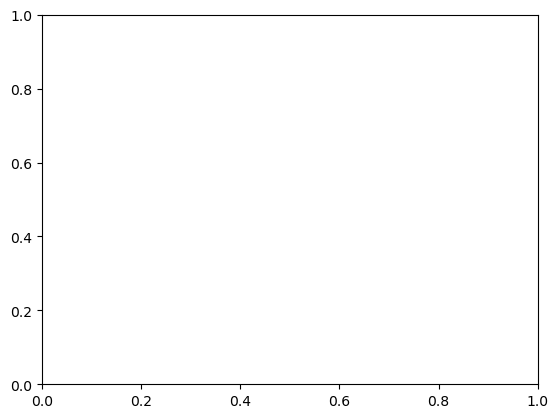

In [29]:
metric = 'Odds Ratio'

plt.figure()

for term in terms: 
    or_ = [res[lambda x: x.Term == term][metric] for res in ress]
    plt.plot(or_, label=term)

plt.xlabel('Time')
plt.ylabel(metric)
#plt.yscale('log')
# put legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show() 

In [30]:
import statsmodels.api as sm

In [31]:
all_terms = set() 
for res in ress:
    all_terms.update(res.Term.values.tolist())
all_terms = list(all_terms)
print(len(all_terms), 'unique terms found')

sign_res = {'Term':[], 'weight':[], 'pval':[]}
for i,term in enumerate(all_terms): 
    print(f'Processing term {i+1}/{len(all_terms)}', end='\r')
    
    try: 
        # for each term, is it increasing or decreasing over time?
        x = np.linspace(0, 1, len(ress))
        y = np.array([res[lambda x: x.Term == term]['Odds Ratio'] for res in ress])

        x = sm.add_constant(x)

        model = sm.OLS(y, x)

        results = model.fit()
        
        sign_res['Term'].append(term)
        sign_res['weight'].append(results.params[1])
        sign_res['pval'].append(results.pvalues[1])
    except:
        pass 
    
sign_res = pd.DataFrame(sign_res)
    


1636 unique terms found


In [32]:
# increasing 
sign_res[lambda x: (x.weight > 0) & (x.pval < 0.05)].sort_values('pval', ascending=True).head(50).Term.values.tolist()

['positive regulation of neuron death (GO:1901216)',
 'cellular response to glucose starvation (GO:0042149)',
 'positive regulation of cellular component movement (GO:0051272)',
 'positive regulation of cellular process (GO:0048522)',
 'positive regulation of protein-containing complex assembly (GO:0031334)',
 'negative regulation of MAPK cascade (GO:0043409)',
 'transcription, DNA-templated (GO:0006351)',
 'positive regulation of chemokine production (GO:0032722)',
 'regulation of protein export from nucleus (GO:0046825)',
 'ERK1 and ERK2 cascade (GO:0070371)',
 'cellular response to heparin (GO:0071504)',
 'positive regulation of leukocyte adhesion to vascular endothelial cell (GO:1904996)',
 'bone marrow development (GO:0048539)',
 'oxygen transport (GO:0015671)',
 'positive regulation of hormone metabolic process (GO:0032352)',
 'regulation of ketone biosynthetic process (GO:0010566)',
 'cellular response to antibiotic (GO:0071236)',
 'energy derivation by oxidation of organic comp

In [33]:
# decreasing
sign_res[lambda x: (x.weight < 0) & (x.pval < 0.05)].sort_values('pval', ascending=True).head(50).Term.values.tolist()

['MAPK cascade (GO:0000165)',
 'positive regulation of transferase activity (GO:0051347)',
 'transmembrane receptor protein tyrosine kinase signaling pathway (GO:0007169)',
 'small GTPase mediated signal transduction (GO:0007264)',
 'cellular response to interleukin-1 (GO:0071347)',
 'positive regulation of cytokine production (GO:0001819)',
 'positive regulation of DNA-binding transcription factor activity (GO:0051091)',
 'protein phosphorylation (GO:0006468)',
 'response to peptide hormone (GO:0043434)',
 'positive regulation of protein kinase B signaling (GO:0051897)',
 'regulation of protein kinase B signaling (GO:0051896)',
 'positive regulation of gene silencing by miRNA (GO:2000637)',
 'Ras protein signal transduction (GO:0007265)',
 'G1/S transition of mitotic cell cycle (GO:0000082)',
 'protein autophosphorylation (GO:0046777)']

In [ ]:
# remove any nodes that is not an ancestor of the target node 
target_node = 'RNA__P46926'
ancestors = nx.ancestors(G, target_node)
G = G.subgraph(list(ancestors) + [target_node]) 
len(G)

NameError: name 'G' is not defined

In [ ]:
# add node type 
for node in G.nodes():
    node_type, uniprot_id = node.split('__')
    nx.set_node_attributes(G, {node: node_type}, 'node_type')

    try: 
        gene_name = list(mapping.map_name(uniprot_id, 'uniprot', 'genesymbol'))[0]
    except: 
        gene_name = uniprot_id

    nx.set_node_attributes(G, {node: gene_name}, 'node_name')

    #G = nx.relabel_nodes(G, {node: gene_name + f'-{suffix}'})

len(G)

59

In [ ]:
H = nx.convert_node_labels_to_integers(G, label_attribute="node_label")
H_layout = nx.nx_pydot.pydot_layout(H, prog="dot")
pos = {H.nodes[n]["node_label"]: p for n, p in H_layout.items()}

In [ ]:
node_color = []
for node in G.nodes(): 
    node_type = G.nodes[node]['node_type']
    if node_type == 'RNA':
        node_color.append('r')
    elif node_type == 'PROTEIN':
        node_color.append('g')
    elif node_type == 'DRUG':
        node_color.append('b')
    else: 
        node_color.append('gray')

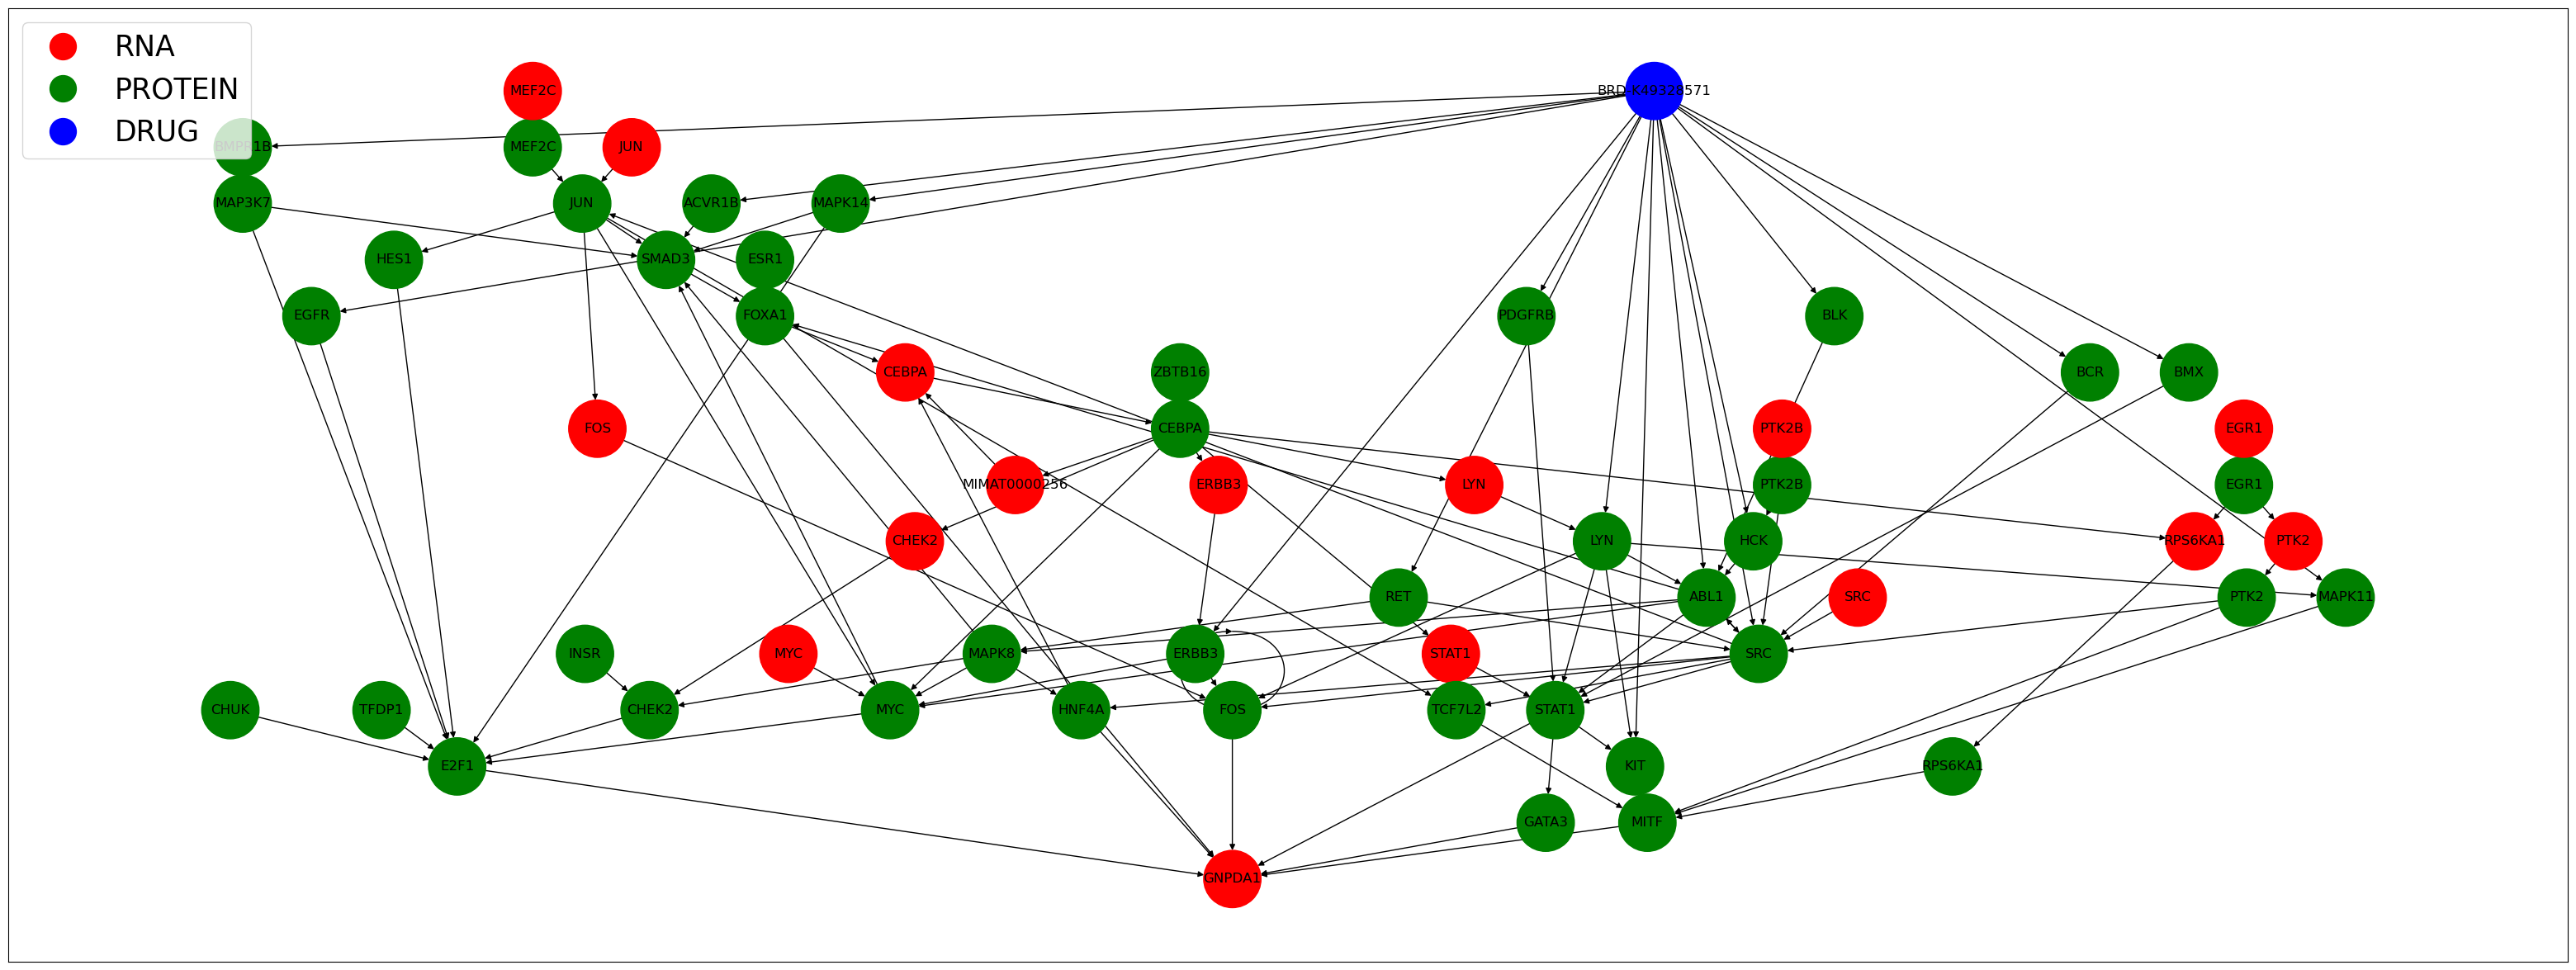

In [ ]:
ns = 2500


plt.figure(figsize=(40,15)) 
nx.draw_networkx_nodes(G, pos, node_size=ns, alpha=1., node_shape='o', node_color=node_color)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=1., node_size=ns)
nx.draw_networkx_labels(G, pos, font_size=12, font_color='black', font_family='sans-serif', labels={n: G.nodes[n]['node_name'] for n in G.nodes()})

plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='RNA', markerfacecolor='r', markersize=25),
    plt.Line2D([0], [0], marker='o', color='w', label='PROTEIN', markerfacecolor='g', markersize=25),
    plt.Line2D([0], [0], marker='o', color='w', label='DRUG', markerfacecolor='b', markersize=25)
], loc='upper left', fontsize=25)
plt.show() 

In [ ]:
G['MYC']

AtlasView({'SMAD3': {}, 'E2F1': {}, 'MYC': {}})

In [ ]:
G['E2F1']

AtlasView({'GNPDA1': {}})

In [ ]:
nx.get_node_attributes(G, 'id')['GNPDA1']

'P46926'

In [ ]:
nx.get_node_attributes(G, 'id')['MYC']


'P01106'

In [ ]:
nx.get_node_attributes(G, 'id')['E2F1']

'Q01094'

In [ ]:
G['PTK2B']

AtlasView({'SRC': {}, 'HCK': {}, 'PTK2B': {}})

In [ ]:
src,dst = data.edge_index_dict['function', 'to', 'function'].detach().cpu().numpy()
node_names = np.array(data.node_names_dict['function'])

src_names = node_names[src]
dst_names = node_names[dst]
edges = pd.DataFrame({'src': src_names, 'dst': dst_names}) 
edges.head()

src          dst
0  PROTEIN__P01106  RNA__O14746
1  PROTEIN__P05412  RNA__P84022
2  PROTEIN__P84022  RNA__P05412
3  PROTEIN__Q13485  RNA__P05412
4  PROTEIN__Q04206  RNA__P25445

In [ ]:
edges[lambda x: x.src == 'RNA__P01106']

src              dst
22909  RNA__P01106  PROTEIN__P01106

In [ ]:
edges[lambda x: (x.src == 'PROTEIN__Q01094') & (x.dst == 'RNA__P01106') ]

src          dst
1131  PROTEIN__Q01094  RNA__P01106

In [ ]:
edges[lambda x: (x.src == 'PROTEIN__Q01094') & (x.dst == 'RNA__P46926') ]

src          dst
4742  PROTEIN__Q01094  RNA__P46926

In [ ]:
edges[lambda x: (x.dst == 'PROTEIN__Q01094') & (x.src == 'RNA__P46926') ]

Empty DataFrame
Columns: [src, dst]
Index: []